# Dataset Augmentation using Generative Adversarial Networks (G.A.N)

#### Farees Siddiqui [100-780-513], Conor Bradley [100-559-961], Nicholas Kissoon [100-742-790]  


For this project we decided to tackle the problem of dataset augmentation, Very often when trying to construct a machine learning model we simply do not have enough training data. This problem can be solved with the help of a Generative Adverserial Network. 

As the name implies this is a generative model, for our example we will be using this technique to generate new data for the MNIST dataset. 

This model works similar to the Encoder Decoder model that we discussed in class, but instead of encoding some data to a lower dimension, this model is used to generate completely brad new data from random noise.

The model is constructed using 2 main parts, the Generator and the Discriminator

The generator tries to Generate data based on the training data

The discriminator is a classifier that outputs a probability of whether or not it thinks the output of the generator was taking from the original dataset or generated. We want this probability to be as close to 1 as possible as that signifies that the discriminator thinks the data was taken straight from the dataset

In [84]:
import os
import torch
import torchvision
import imageio
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from torch.utils.data import DataLoader
from IPython.display import Image
from torchvision.utils import save_image

In [50]:
# Use GPU for training if available

print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"
device

True


'cuda'

In [51]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = torchvision.datasets.MNIST("./data", download=True, transform=transform)

In [52]:
print(f'[dataset shape: {dataset.data.shape} and type: {type(dataset.data)}]\n[target shape: {dataset.targets.shape} and type: {type(dataset.targets)}]')

[dataset shape: torch.Size([60000, 28, 28]) and type: <class 'torch.Tensor'>]
[target shape: torch.Size([60000]) and type: <class 'torch.Tensor'>]


In [53]:
# Looking at the data
x, y = dataset[0]
x.shape, type(y)

(torch.Size([1, 28, 28]), int)

Text(0.5, 1.0, 'Label: 5')

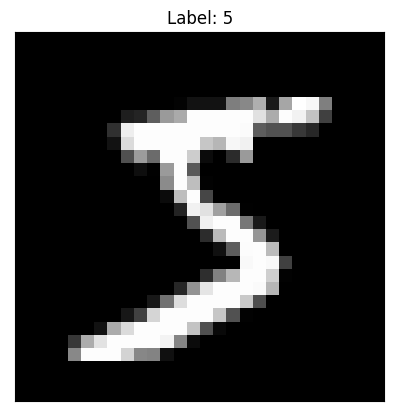

In [54]:
x.squeeze_()
plt.imshow(x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(f'Label: {y}')

In [55]:
img, label = dataset[0]
print(f'Label: {label}')
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label: 5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

Label: 5


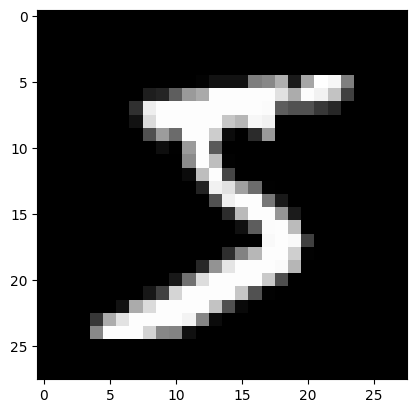

In [56]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print(f'Label: {label}')

In [57]:
batch_size = 100
dataloader = DataLoader(dataset, batch_size, shuffle=True)

First batch:
torch.Size([100, 1, 28, 28])
tensor([2, 6, 2, 5, 6, 1, 2, 7, 6, 4, 7, 8, 8, 3, 6, 3, 5, 3, 0, 9, 8, 6, 7, 6,
        8, 4, 8, 6, 9, 1, 3, 3, 5, 8, 1, 2, 0, 9, 2, 1, 8, 4, 4, 0, 0, 3, 0, 9,
        8, 4, 3, 4, 5, 4, 6, 8, 3, 1, 9, 5, 4, 0, 5, 7, 6, 9, 9, 0, 2, 8, 5, 3,
        9, 1, 7, 6, 1, 2, 5, 0, 1, 2, 4, 6, 1, 4, 0, 9, 9, 9, 9, 7, 9, 7, 9, 5,
        3, 1, 5, 1])


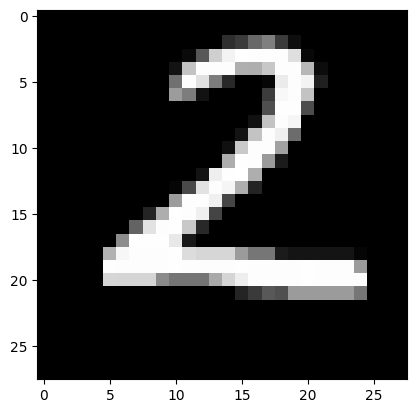

In [58]:
for img_batch, label_batch in dataloader:
    print('First batch:')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [59]:
img_size = 784 # (28*28)
hidden_size = 256

In [60]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(img_size, hidden_size)
        self.leakyReLU = nn.LeakyReLU(0.2)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.leakyReLU(x)
        x = self.linear2(x)
        x = self.leakyReLU(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
discriminator = DiscriminatorModel()
discriminator = discriminator.to(device)
discriminator

DiscriminatorModel(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (leakyReLU): LeakyReLU(negative_slope=0.2)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [61]:
latent_size = 64

class GeneratorModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.ReLU = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, img_size)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.ReLU(x)
        x = self.linear2(x)
        x = self.ReLU(x)
        x = self.fc(x)
        x = self.tanh(x)
        return x

generator = GeneratorModel()
generator = generator.to(device)
generator

GeneratorModel(
  (linear1): Linear(in_features=64, out_features=256, bias=True)
  (ReLU): ReLU()
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=784, bias=True)
  (tanh): Tanh()
)

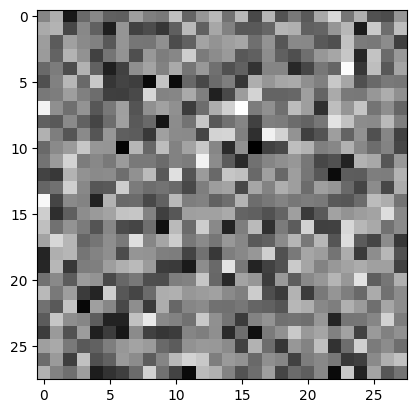

In [62]:
z = torch.randn(2, latent_size).to(device)
Y = generator(z)
gen_imgs = denorm(Y.reshape((-1, 28, 28)).detach().cpu())
plt.imshow(gen_imgs[0], cmap='gray')

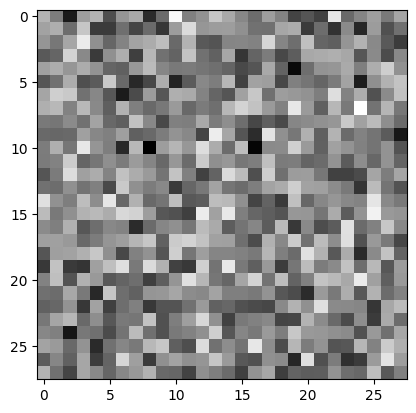

In [63]:
plt.imshow(gen_imgs[1], cmap='gray')

In [64]:
loss = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# print the number of parameters in the discriminator and generator
print("[Discriminator] Number of parameters: %d" % sum(p.numel() for p in discriminator.parameters()))
print("[Generator] Number of parameters: %d" % sum(p.numel() for p in generator.parameters()))

[Discriminator] Number of parameters: 267009
[Generator] Number of parameters: 283920


In [65]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [66]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    outputs = discriminator(images)
    d_loss_real = loss(outputs, real_labels)
    real_score = outputs
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = loss(outputs, fake_labels)
    fake_score = outputs
    
    d_loss = d_loss_real + d_loss_fake
    reset_grad
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score
    

In [67]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = loss(discriminator(fake_images), labels)
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [68]:
sample_dir = 'output'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

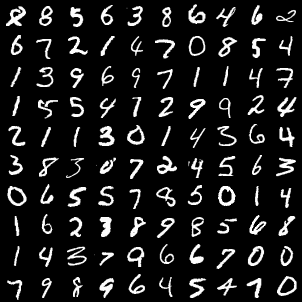

In [69]:
for images, _ in dataloader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


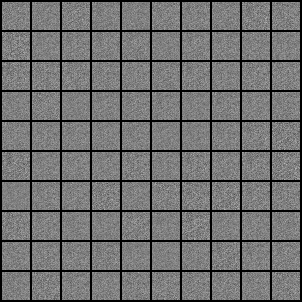

In [70]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Save before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [74]:
%%time
start0 = time.time()
num_epochs = 300
total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        images = images.reshape(batch_size, -1).to(device)
        
        # training the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, Disc_real_image: {:.2f}, Disc_gen_image: {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                                                                                                                      real_score.mean().item(), fake_score.mean().item()))
    save_fake_images(epoch+1)
duration0 = time.time() - start0
print('Total time: {:.2f}s'.format(duration0))

Epoch [0/300], Step [200/600], d_loss: 1.0167, g_loss: 0.6986, Disc_real_image: 0.93, Disc_gen_image: 0.60
Epoch [0/300], Step [400/600], d_loss: 0.8103, g_loss: 0.6062, Disc_real_image: 0.92, Disc_gen_image: 0.51
Epoch [0/300], Step [600/600], d_loss: 0.8210, g_loss: 0.6207, Disc_real_image: 0.98, Disc_gen_image: 0.54
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.9384, g_loss: 0.6683, Disc_real_image: 0.93, Disc_gen_image: 0.57
Epoch [1/300], Step [400/600], d_loss: 0.9560, g_loss: 0.7698, Disc_real_image: 0.91, Disc_gen_image: 0.56
Epoch [1/300], Step [600/600], d_loss: 0.9075, g_loss: 0.6769, Disc_real_image: 0.97, Disc_gen_image: 0.57
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8737, g_loss: 0.6851, Disc_real_image: 0.94, Disc_gen_image: 0.55
Epoch [2/300], Step [400/600], d_loss: 1.1732, g_loss: 0.5163, Disc_real_image: 0.88, Disc_gen_image: 0.64
Epoch [2/300], Step [600/600], d_loss: 1.1334, g_loss: 0.6517, Disc_real_image: 0.92, Di

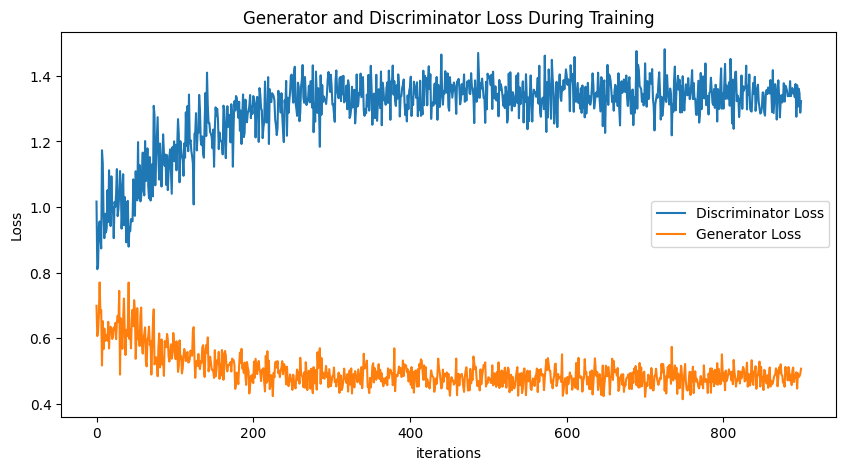

In [87]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_losses,label="Discriminator Loss")
plt.plot(g_losses,label="Generator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [78]:
# save the model 
torch.save(generator.state_dict(), './MNIST_Generator.pt')
torch.save(discriminator.state_dict(), './MNIST_Discriminator.pt')

In [81]:
def load_images_from_dir(directory):
    image_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image = imageio.imread(os.path.join(directory, filename))
            image_list.append(image)
    return image_list

images = load_images_from_dir(sample_dir)
imageio.mimsave('output/out.gif', images, fps=20)

C:\Users\faree\AppData\Local\Temp\ipykernel_7360\456747677.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(directory, filename))


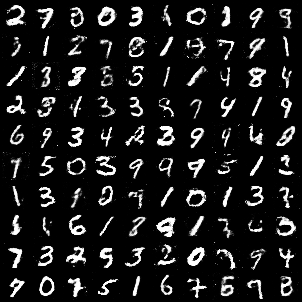

In [88]:
# Load the model parameters
generator.load_state_dict(torch.load('./MNIST_Generator.pt'))
discriminator.load_state_dict(torch.load('./MNIST_Discriminator.pt'))

# make a prediction
z = torch.randn(batch_size, latent_size).to(device)
fake_images = generator(z)
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images.png'), nrow=10)
Image(os.path.join(sample_dir, 'fake_images.png'))
